# KymoButlerAnalyzer

The following script is intended to batch compile, extract, and analyze data from KymoButler results files. KymoButler is an AI program that analyzes kymographs made by Max Jakobs: https://github.com/MaxJakobs/KymoButler. 

After running KymoButler to analyze kymographs, you should have a results file for each kymograph analyzed. The following script assumes you have a directory with these excel files for each condition of data you have (ex conditions: wildtype vs mutant). This script can either analyze one replicate of an experiment, or multiple replicates at once. It will loop through each set of KymoButler results files, extract different metrics based on direction (ex. anterograde track durations) as well as counting the number of tracks per direction, then compile these results from every file together and save these compiled results in kymo_results folder ({condition_name}_compiled_results.xlsx). Then it will calculate the mean value of each metric per file, and compile that onto a new excel file with the means from the other conditions as well (mean_compiled_results.xlsx). These means can optionally be normalized to the first condition's mean (conditionX*(conditionX_mean/condition1_mean)). Then it performs statistical analysis (t-tests and anova) on the means of every metric, and exports that data into an excel file (statistical_test_results.xlsx). Then it creates violin plots and histogram plots for each metric, and saves these as both PNGs and PDFs. Optionally, it will also create a grid of all kymographs per condition.

### Directions:

1. Create kymographs using Fiji/ImageJ or some other image analysis tool. Save them as PNGs in individual folders in a directory (have different directories for different conditions)
2. Run KymoButler batch script on the directory, it will loop through each folder, do analysis on the PNG in that folder (only have one PNG per folder), then output the results files in the chosen directory
3. Run the following script, it will as you several prompts:

    a. Enter the number of conditions you intend to analyze (statistical analysis necessitates at least 2 conditions)

    b. Enter the name of each condition (this should be the SAME names as your folder names for each condition, make sure these folder names are the same across all replicates)

    c. Enter 'Y' if you intend to analyze more than one replicate of data, 'N' if not

    d. Enter 'Y' if you want to normalize the data to the mean of the first condition, 'N' if not

    e. Enter 'Y' if you want to create a grid of all your kymographs per condition, 'N' if not (note: kymograph PNGs are expected to be within individual folders within the condition folder)
        
        Directory Example: C:\User\username\Desktop\Replicates\Replicate1\Condition1\Kymograph1\Kymograph.png
    
    f. Choose the directory you wish to analyze, if you said 'Y' to replicates, choose the directory that contains all your replicate folders (a replicate is one iteration of an experiment, it is expected that each replicate has the same condition folder names within it), if you wish to analyze a single replicate, choose the directory of one replicate

        Multiple Replicates Chosen Directory: C:\User\username\Desktop\Replicates

        Single Replicate Chosen Directory: C:\User\username\Desktop\Replicates\Replicate1


        KymoButler Results File Directory Example: C:\User\username\Desktop\Replicates\Replicate1\Condition1\kymograph1.xlsx

### Tips for Troubleshooting
1. When analyzing multiple replicates, the chosen directory should only contain the replicate folders, which each contain condition subfolders (make sure the condition folders have the same names across replicates and that you enter them correctly when prompted)
2. Make sure your kymographs are each in their own folder within the condition folders and that there is only one PNG per folder
3. Make sure your KymoButler results files are all located within the condition folders

Directory chosen: C:/Users/oes6098/Desktop/test lysos2/fake replicate
Processing single replicate: C:/Users/oes6098/Desktop/test lysos2/fake replicate
  Processing condition: 27del
  Processing condition: 854
Dataframes created and saved successfully!
Mean value calculation and saving completed.
Statistical test results saved.


C:\Users\oes6098\AppData\Local\Temp\ipykernel_21412\3443980055.py:278: DegenerateDataWarning: at least one input has length 0
  anova_result = f_oneway(*anova_samples)


Plots saved.


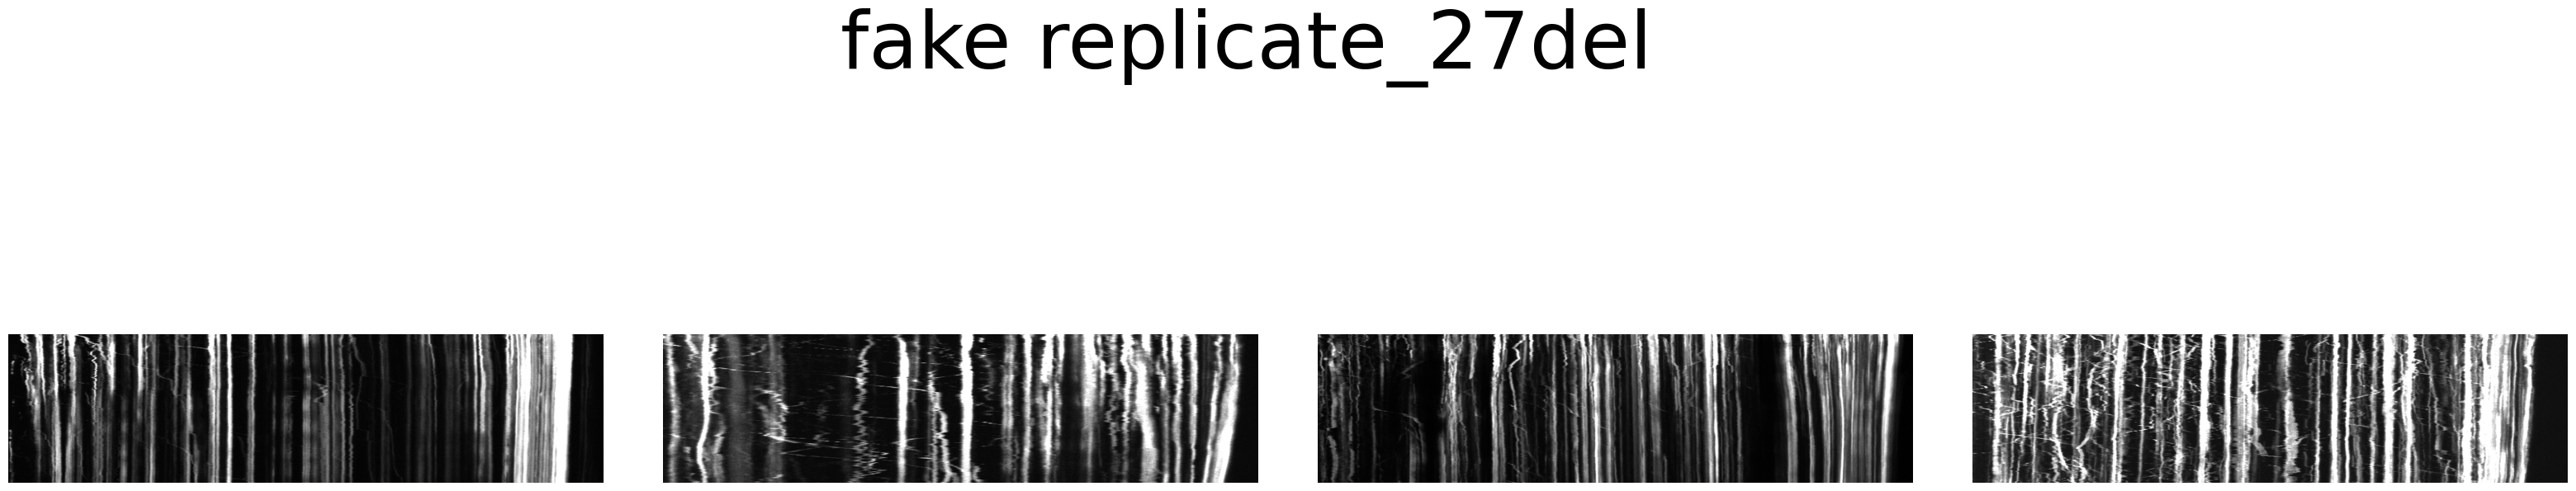

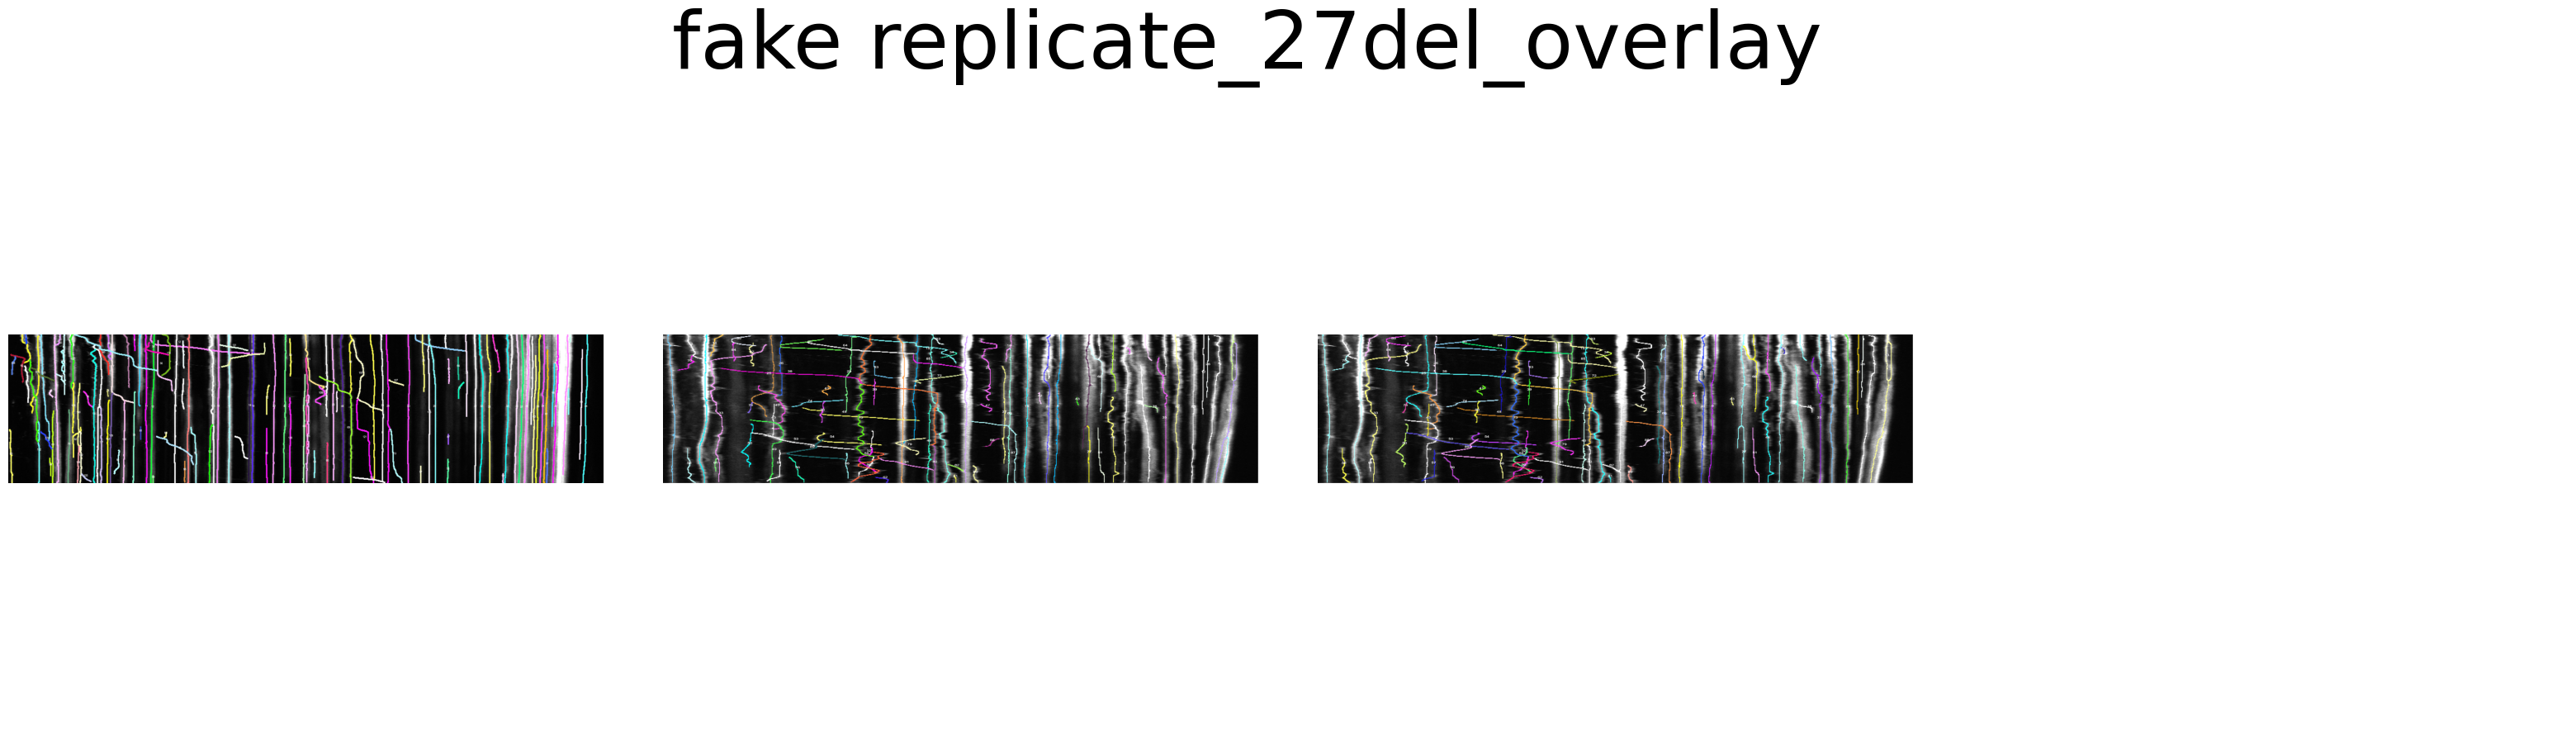

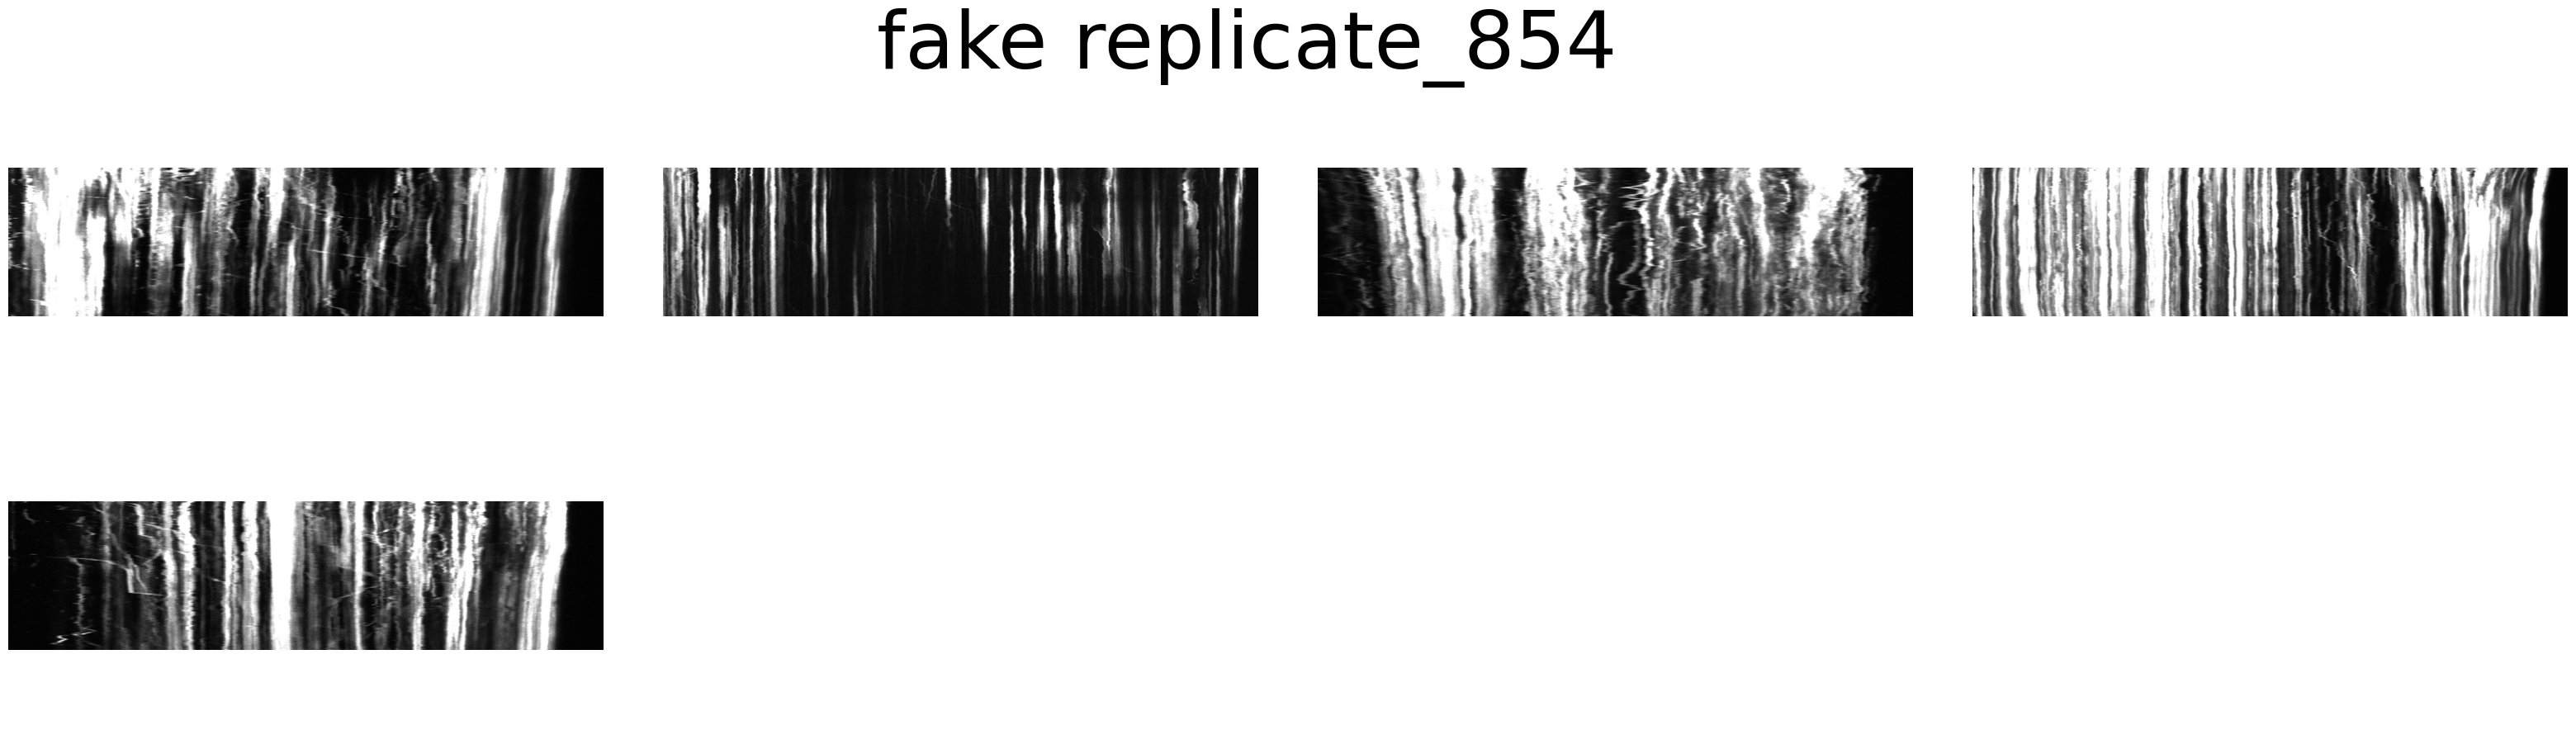

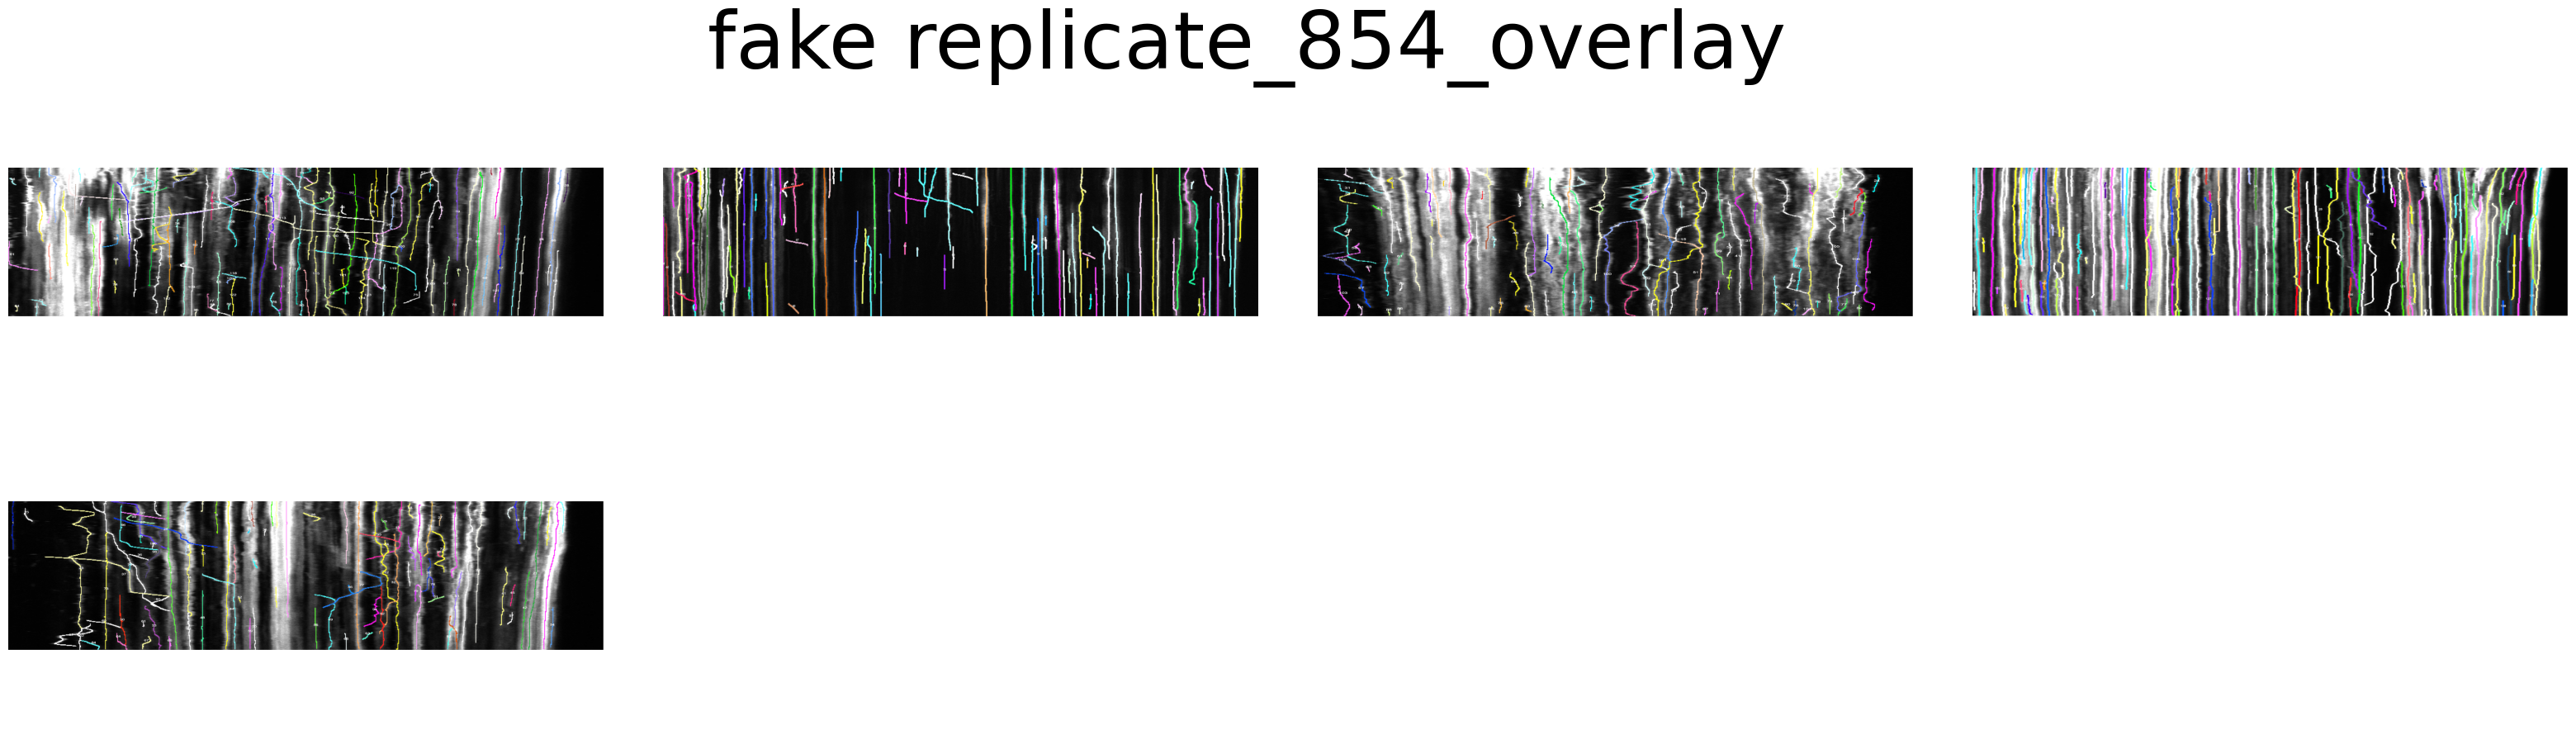

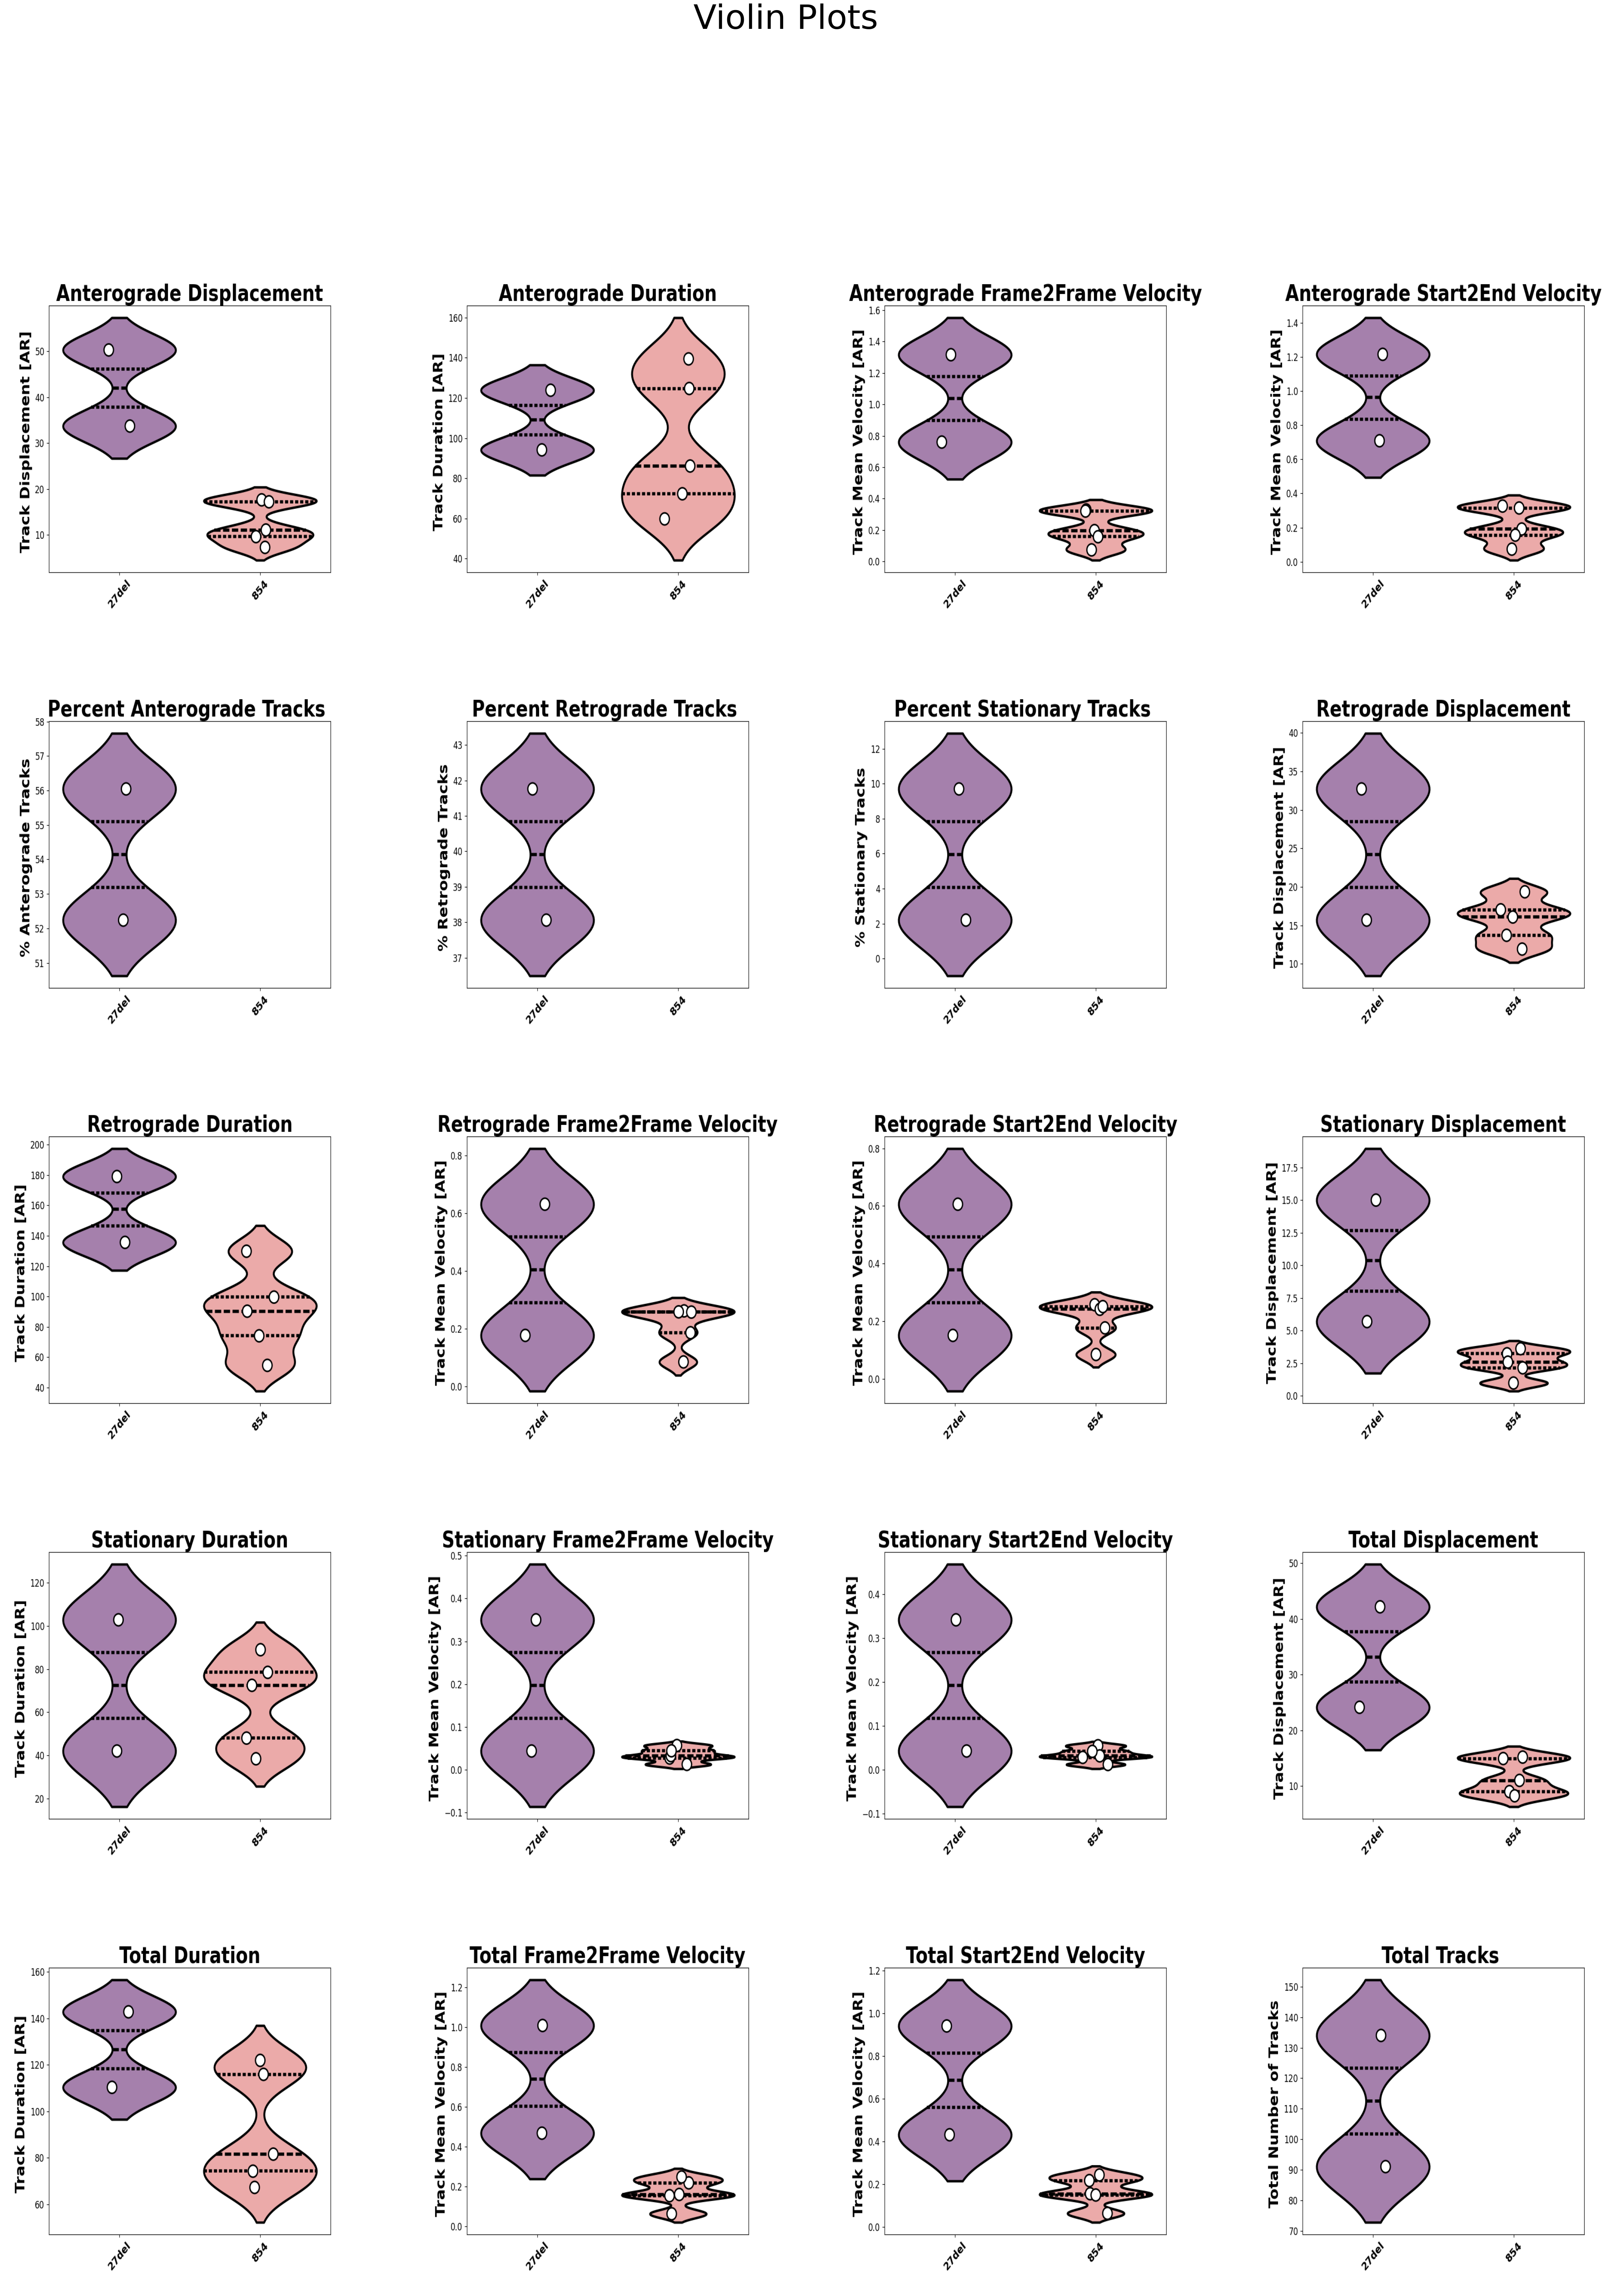

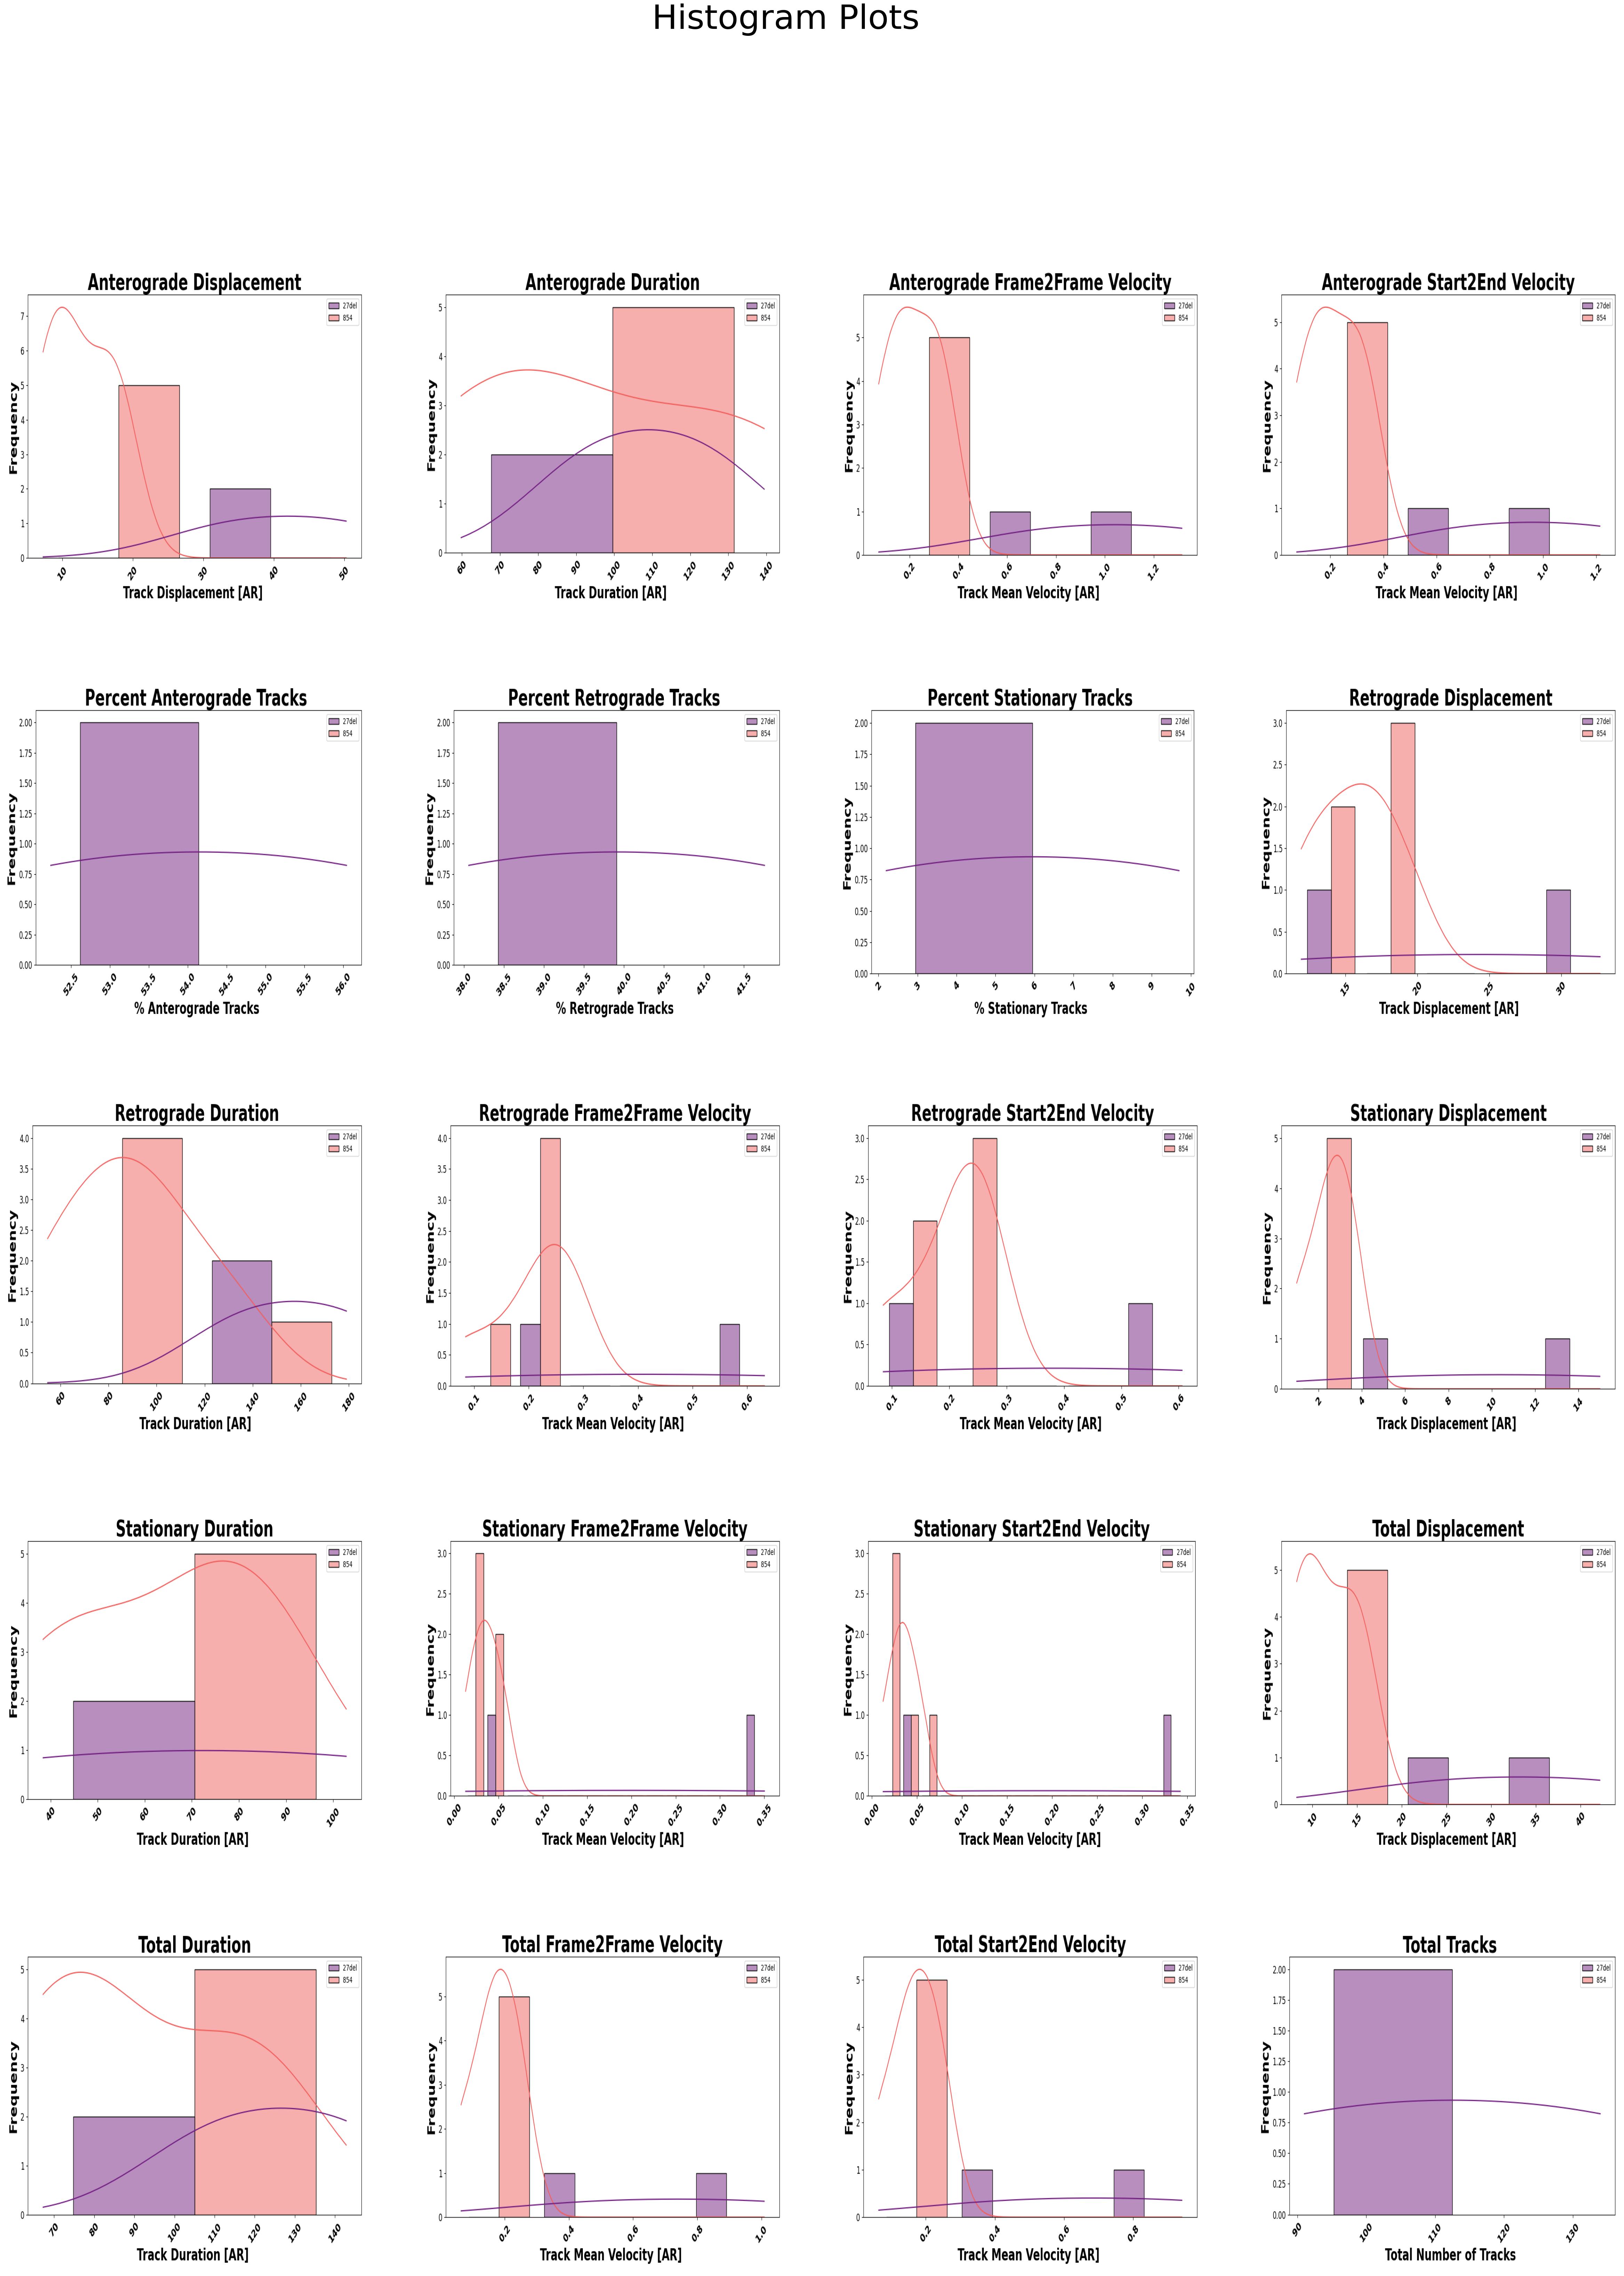

Grid saved


In [1]:
import os
import pandas as pd
import numpy as np
import warnings
import sys
from tkinter import filedialog
import tkinter as tk
from scipy.stats import ttest_ind, f_oneway
import seaborn as sns
import matplotlib.pyplot as plt
import KymoButlerAnalyzerFunctions as kymo

# Suppress the specific UserWarning from openpyxl
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

#Prompt the user for the number of conditions and their names
num_conditions = int(input("Enter the number of conditions: "))

#Check if the number of conditions is 1
if num_conditions == 1:
    print("T-tests and ANOVA tests cannot be performed on a single condition. Exiting program.")
    sys.exit()

condition_names = []
for i in range(num_conditions):
    folder_name = input(f"Enter the folder name for condition {i + 1}: ")
    condition_names.append(folder_name)


# Ask the user if they have one replicate or multiple replicates of data
replicate_input = input("Do you have more than one replicate? (Enter y/n): ")
replicates = replicate_input.lower() in ['y', 'yes']

normalize_input = input('Do you want to normalize all conditions to the mean of condition 1? (Enter y/n): ')
normalized = normalize_input.lower() in ['y', 'yes']

kymogrid_input = input('Do you want to create a grid of your kymographs for each condition? (Enter y/n): ')
kymogrid = kymogrid_input.lower() in ['y', 'yes']

# Create a Tkinter root window
root = tk.Tk()
root.withdraw()  # Hide the root window

if replicates:
    directory = filedialog.askdirectory(title="Select Directory Containing Replicate Folders")
else:
    directory = filedialog.askdirectory(title="Select Directory Containing Condition Folders")

print('Directory chosen:', directory)

# Check if a directory was selected
if not directory:
    print("No directory selected. Exiting...")
    exit()


# Check if all required folders exist, if not, exit the program
if replicates:
    replicate_folders = os.listdir(directory)
    condition_paths = []
    for folder in replicate_folders:
        if folder not in ['kymo_results']:
            condition_paths.append([os.path.join(directory, folder, condition) for condition in condition_names])
            if not all(os.path.exists(folder) for folder in condition_paths[-1]):
                print("One or more required folders are missing.")
                sys.exit()
else:
    condition_paths = [os.path.join(directory, folder) for folder in condition_names]
    if not all(os.path.exists(folder) for folder in condition_paths):
        print("One or more required folders are missing.")
        sys.exit()


# Column names to be extracted from Excel files
column_mapping = {
    'Av frame2frame velocity [um/sec]': 'frame2frame',
    'track duration [sec]': 'duration',
    'track total displacement [um]': 'displacement',
    'Start2end velocity [um/sec]': 'start2end'
}

metrics=['ANT_frame2frame', 'ANT_duration', 'ANT_displacement', 'ANT_start2end', 
        'RET_frame2frame', 'RET_duration', 'RET_displacement', 'RET_start2end',
        'STAT_frame2frame', 'STAT_duration', 'STAT_displacement', 'STAT_start2end',
        'TOTAL_frame2frame', 'TOTAL_duration', 'TOTAL_displacement', 'TOTAL_start2end']

total_metrics=['ANT_frame2frame', 'ANT_duration', 'ANT_displacement', 'ANT_start2end', 
        'RET_frame2frame', 'RET_duration', 'RET_displacement', 'RET_start2end',
        'STAT_frame2frame', 'STAT_duration', 'STAT_displacement', 'STAT_start2end',
        'TOTAL_frame2frame', 'TOTAL_duration', 'TOTAL_displacement', 'TOTAL_start2end',
        'total_tracks','percent_anterograde', 'percent_retrograde', 'percent_stationary']

# Initialize dictionaries to store dataframes for each condition
dataframes = {}

# Initialize dataframes for each condition
for condition in condition_names:
    dataframes[condition] = {
        f'{condition}_directions': pd.DataFrame(columns=[
            'anterograde tracks', 'retrograde tracks', 'stationary tracks', 'total tracks', 
            'percent anterograde', 'percent retrograde', 'percent stationary']),
        f'{condition}_ANT_frame2frame': pd.DataFrame(),
        f'{condition}_ANT_duration': pd.DataFrame(),
        f'{condition}_ANT_displacement': pd.DataFrame(),
        f'{condition}_ANT_start2end': pd.DataFrame(),
        f'{condition}_RET_frame2frame': pd.DataFrame(),
        f'{condition}_RET_duration': pd.DataFrame(),
        f'{condition}_RET_displacement': pd.DataFrame(),
        f'{condition}_RET_start2end': pd.DataFrame(),
        f'{condition}_STAT_frame2frame': pd.DataFrame(),
        f'{condition}_STAT_duration': pd.DataFrame(),
        f'{condition}_STAT_displacement': pd.DataFrame(),
        f'{condition}_STAT_start2end': pd.DataFrame(),
        f'{condition}_TOTAL_frame2frame': pd.DataFrame(),
        f'{condition}_TOTAL_duration': pd.DataFrame(),
        f'{condition}_TOTAL_displacement': pd.DataFrame(),
        f'{condition}_TOTAL_start2end': pd.DataFrame(),
    }

# Create the kymo_results folder in the chosen directory
kymo_results_folder = os.path.join(directory, 'kymo_results')
if not os.path.exists(kymo_results_folder):
    os.makedirs(kymo_results_folder)

# Create a folder for graphs
if normalized:
    graphs_folder = os.path.join(kymo_results_folder, 'normalized_graphs')
    if not os.path.exists(graphs_folder):
        os.makedirs(graphs_folder)

else:
    graphs_folder = os.path.join(kymo_results_folder, 'graphs')
    if not os.path.exists(graphs_folder):
        os.makedirs(graphs_folder)

kymogrid_folder = os.path.join(kymo_results_folder, 'kymogrids')
if not os.path.exists(kymogrid_folder):
    os.makedirs(kymogrid_folder)

# Extract and compile data across multiple replicates or a single replicate
if replicates:
    print("Processing multiple replicates...")
    rownumber = 0
    for replicate_folder in os.listdir(directory):
        replicate_path = os.path.join(directory, replicate_folder)

        if not os.path.isdir(replicate_path) or replicate_folder == 'kymo_results': #Ignore kymo_results folder if its already there
            continue

        print(f"Processing replicate: {replicate_folder}")
        rows=kymo.process_data(path=replicate_path, conditionnames=condition_names, dfs=dataframes, columnmapping=column_mapping, results_folder=kymo_results_folder, grid_folder=kymogrid_folder, kymo_grid=kymogrid, row_number=rownumber)
        rownumber=rows

else:
    print("Processing single replicate:", directory)
    kymo.process_data(path=directory, conditionnames=condition_names, dfs=dataframes, columnmapping=column_mapping, results_folder=kymo_results_folder, grid_folder=kymogrid_folder, kymo_grid=kymogrid) 

''' 
Calculate Mean Values
'''
mean_df_dict = {}

# Calculate mean value for each column
for metric in metrics:
    mean_df_dict[metric] = pd.DataFrame(index=range(500))

    # Determine the reference condition for normalization
    reference_condition = condition_names[0]  # Assuming the first condition is the reference

    for condition in condition_names:
        df = dataframes[condition].get(f'{condition}_{metric}')
        if df is not None and not df.empty:
            mean_values = df.mean(axis=0, skipna=True)
            # Convert mean values to list
            mean_values_list = mean_values.tolist()
            # Add NaN values to make the list length equal to 500 (this allows each condition to be a different length in df)
            mean_values_list.extend([np.nan] * (500 - len(mean_values_list)))
            # Fill in the mean values into the DataFrame
            mean_df_dict[metric][condition] = mean_values_list
        else:
            print(f"No data found for condition {condition} and metric {metric}")

    # Normalize values to the mean of the reference condition
    if normalized:
        # Extract the mean values of the reference condition
        scale_factor = mean_df_dict[metric][reference_condition].mean()

        for condition in condition_names:
            if condition != reference_condition:
                # Normalize the current condition by dividing by the scale factor
                mean_df_dict[metric][condition] = mean_df_dict[metric][condition]*(mean_df_dict[metric][condition].mean() / scale_factor)

# Save the mean DataFrames to a single Excel file with each metric in a separate sheet
if normalized:
    mean_excel_path = os.path.join(kymo_results_folder, 'normalized_mean_values.xlsx')
else:
    mean_excel_path = os.path.join(kymo_results_folder, 'mean_values.xlsx')
with pd.ExcelWriter(mean_excel_path) as writer:
    for metric, mean_df in mean_df_dict.items():
        # Truncate the title if it exceeds 31 characters
        sheet_name = metric[:31]
        mean_df.to_excel(writer, sheet_name=sheet_name, index=False)

print("Mean value calculation and saving completed.")

# Extract data about number of tracks per direction and put on new dataframes
direction_df_dict = {
    'total_tracks': pd.DataFrame(),
    'percent_anterograde': pd.DataFrame(),
    'percent_retrograde': pd.DataFrame(),
    'percent_stationary': pd.DataFrame()
}

for condition in condition_names:
    # Extract the respective column from the directions DataFrame for the current condition
    total_tracks = dataframes[condition][f'{condition}_directions']['total tracks']
    percent_anterograde = dataframes[condition][f'{condition}_directions']['percent anterograde']
    percent_retrograde = dataframes[condition][f'{condition}_directions']['percent retrograde']
    percent_stationary = dataframes[condition][f'{condition}_directions']['percent stationary']
    
    # Add the columns to the respective DataFrames in the summary DataFrame dictionary
    direction_df_dict['total_tracks'][condition] = total_tracks
    direction_df_dict['percent_anterograde'][condition] = percent_anterograde
    direction_df_dict['percent_retrograde'][condition] = percent_retrograde
    direction_df_dict['percent_stationary'][condition] = percent_stationary

# Create a new dictionary to store all dataframes 
all_df_dict = {}

# Copy dataframes from mean_df_dict
for title, mean_df in mean_df_dict.items():
    all_df_dict[title] = mean_df.copy()

# Copy dataframes from direction_df_dict
for title, direction_df in direction_df_dict.items():
    all_df_dict[title] = direction_df.copy()


'''
Statistical Analysis
'''

# Initialize a dictionary to store t-test and ANOVA results for each dataframe
stats_results_dict = {metric: [] for metric in all_df_dict}

# Perform t-tests and ANOVA for each dataframe
for metric, mean_df in all_df_dict.items():
    # Perform t-tests for each pair of conditions
    for i in range(len(condition_names)):
        for j in range(i+1, len(condition_names)):
            condition1 = condition_names[i]
            condition2 = condition_names[j]
            
            # Perform t-test
            t_statistic, p_value = ttest_ind(mean_df[condition1].dropna(), mean_df[condition2].dropna())
            
            # Determine significance level
            if p_value < 0.0001:
                significance = '****'
            elif p_value < 0.001:
                significance = '***'
            elif p_value < 0.01:
                significance = '**'
            elif p_value < 0.05:
                significance = '*'
            else:
                significance = 'ns'
            
            # Append t-test results to the dictionary
            stats_results_dict[metric].append({'Comparison': f"T-test between {condition1} and {condition2} ({metric}):",
                                            'T-Statistic or F-Statistic': t_statistic,
                                            'P-Value': p_value,
                                            'Significance': significance})
    
    # Perform ANOVA if there are 2 or more conditions
    if len(condition_names) >= 2:
        anova_samples = [mean_df[condition].dropna() for condition in condition_names]
        anova_result = f_oneway(*anova_samples)
        
        # Determine ANOVA significance level
        if anova_result.pvalue < 0.0001:
            anova_significance = '****'
        elif anova_result.pvalue < 0.001:
            anova_significance = '***'
        elif anova_result.pvalue < 0.01:
            anova_significance = '**'
        elif anova_result.pvalue < 0.05:
            anova_significance = '*'
        else:
            anova_significance = 'ns'
        
        # Append ANOVA results to the dictionary
        stats_results_dict[metric].append({'Comparison': 'ANOVA:',
                                        'T-Statistic or F-Statistic': anova_result.statistic,
                                        'P-Value': anova_result.pvalue,
                                        'Significance': anova_significance})
        
# Save the statistical test results to an Excel file
if normalized:
    stats_excel_path = os.path.join(kymo_results_folder, 'normalized_statistical_test_results.xlsx')
else:
    stats_excel_path = os.path.join(kymo_results_folder, 'statistical_test_results.xlsx')
with pd.ExcelWriter(stats_excel_path) as writer:
    for metric, stats_results in stats_results_dict.items():
        # Truncate the title if it exceeds 31 characters
        sheet_name = metric[:31]
        
        stats_results_df = pd.DataFrame(stats_results)
        stats_results_df.to_excel(writer, sheet_name=sheet_name, index=False)

print("Statistical test results saved.")

'''
Creating Violin and Histogram Plots
'''

# Perform violin plots for each metric
for title, group_df in all_df_dict.items():
    # Plot settings
    dots_palette = ['white'] * num_conditions
    magma_palette = sns.color_palette("magma", n_colors=num_conditions)
    lighter_palette = [tuple(min(component + 0.4 * (1 - component), 1) for component in color) for color in magma_palette]

    plt.figure(figsize=(8, 6))

    # Extract the mean DataFrame for the current title/metric
    mean_df = all_df_dict[title]

    sns.violinplot(data=mean_df, bw_method=0.3, linewidth=3, palette=lighter_palette, inner='quartile', inner_kws={'color': 'black', 'linewidth': 4}, linecolor='black')
    sns.stripplot(data=mean_df, size=15, palette=dots_palette, linewidth=2, edgecolor='black')

    plot_title = (
        f'{"Anterograde" if "ANT_" in title else "Retrograde" if "RET_" in title else "Total" if "TOTAL_" in title else "Stationary" if "STAT_" in title else "Percent Anterograde Tracks" if "percent_anterograde" in title else "Percent Retrograde Tracks" if "percent_retrograde" in title else "Percent Stationary Tracks" if "percent_stationary" in title else "Total Tracks"} '
        f'{"Duration" if "duration" in title else "Displacement" if "displacement" in title else "Frame2Frame Velocity" if "frame2frame" in title else "Start2End Velocity" if "start2end" in title else ""}'
    )

    plt.title(plot_title, fontsize=28, fontweight='bold')

    ylabel = (
        f'{"Track Mean Velocity [AR]" if "2" in title else "Track Duration [AR]" if "duration" in title else "Track Displacement [AR]" if "displacement" in title else "% Anterograde Tracks" if "percent_anterograde" in title else "% Retrograde Tracks" if "percent_retrograde" in title else "% Stationary Tracks" if "percent_stationary" in title else "Total Number of Tracks"} '
        if normalized else
        f'{"Track Mean Velocity [µm/sec]" if "2" in title else "Track Duration [sec]" if "duration" in title else "Track Displacement [µm]" if "displacement" in title else "% Anterograde Tracks" if "percent_anterograde" in title else "% Retrograde Tracks" if "percent_retrograde" in title else "% Stationary Tracks" if "percent_stationary" in title else "Total Number of Tracks"} '
    )

    plt.ylabel(ylabel, fontsize=20, fontweight='bold')
    plt.xticks(rotation=45, fontsize=14, fontweight='bold')
    plt.tick_params(axis='y', labelsize=12)
    violin_plot_path = os.path.join(graphs_folder, f"{title}_violin_plot.pdf")
    plt.savefig(violin_plot_path)
    plt.savefig(violin_plot_path.replace(".pdf", ".png"))
    plt.close()

    # Histogram plots
    if title in total_metrics:
        data = all_df_dict[title].values
        bins = kymo.calculate_bins(data, method='fd')

        plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

        sns.histplot(data=all_df_dict[title], bins=bins, kde=True, shrink=0.8, multiple='dodge', palette=magma_palette, alpha=0.5, legend=True)
        plt.ylabel('Frequency', fontsize=20, fontweight='bold')
        plt.xticks(rotation=45, fontsize=14, fontweight='bold')

        plt.title(plot_title, fontsize=28, fontweight='bold')

        xlabel = (
            f'{"Track Mean Velocity [AR]" if "2" in title else "Track Duration [AR]" if "duration" in title else "Track Displacement [AR]" if "displacement" in title else "% Anterograde Tracks" if "percent_anterograde" in title else "% Retrograde Tracks" if "percent_retrograde" in title else "% Stationary Tracks" if "percent_stationary" in title else "Total Number of Tracks"} '
            if normalized else
            f'{"Track Mean Velocity [µm/sec]" if "2" in title else "Track Duration [sec]" if "duration" in title else "Track Displacement [µm]" if "displacement" in title else "% Anterograde Tracks" if "percent_anterograde" in title else "% Retrograde Tracks" if "percent_retrograde" in title else "% Stationary Tracks" if "percent_stationary" in title else "Total Number of Tracks"} '
        )

        plt.xlabel(xlabel, fontsize=20, fontweight='bold')
        plt.tight_layout()  # Adjust the layout to prevent overlapping labels

        plt.tick_params(axis='y', labelsize=12)
        hist_plot_path = os.path.join(graphs_folder, f"{title}_hist_plot.pdf")
        plt.savefig(hist_plot_path)
        plt.savefig(hist_plot_path.replace(".pdf", ".png"))
        plt.close()

print("Plots saved.")
kymo.imagegrid("Violin Plots", "violin_plot.png", num_cols=4, directory=graphs_folder) #make grid of violin plots
kymo.imagegrid("Histogram Plots", "hist_plot.png", num_cols=4, directory=graphs_folder) #make grid of histogram plots

print('Grid saved')